# EPASS on Tiny ImageNet (SimMatch-based)

Demonstrates Semi-Supervised Learning using Ensemble Projectors
on the Tiny ImageNet dataset.

## 1. Setup: Imports and Configuration

In [1]:
import os
import time
import math
import random
import shutil
import subprocess
import glob
from tqdm.notebook import tqdm
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split

# Configuration / Hyperparameters
# --- Dataset ---
DATA_DIR = './tiny-imagenet-200'
TINY_IMAGENET_URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
NUM_CLASSES = 200
# --- Training ---
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50 # Increase for better convergence (e.g., 100, 200+)
BATCH_SIZE = 64 # Labeled batch size
MU = 7 # Ratio of unlabeled batch size to labeled batch size (unlabeled_bs = MU * BATCH_SIZE)
LR = 0.03 # Learning rate
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
EMA_DECAY = 0.999 # EMA decay factor for teacher model
THRESHOLD = 0.95 # Confidence threshold for pseudo-labels
LAMBDA_U = 1.0 # Weight for unsupervised consistency loss
LAMBDA_C = 1.0 # Weight for contrastive loss
TEMPERATURE = 0.2 # Temperature for contrastive similarity scaling
# --- EPASS ---
NUM_PROJECTORS = 3 # Number of ensemble projectors (P in the paper)
PROJECTION_DIM = 128 # Output dimension of projectors
# --- Labeled Data ---
LABELED_RATIO = 0.2 # Fraction of training data to use as labeled (e.g., 0.1 for 10%, 0.2 for 20%)
# Labeled data per class calculation:
# Total train images = 100,000
# Total classes = 200
# Images per class = 500
# Labeled images per class = 500 * LABELED_RATIO

print(f"Using Device: {DEVICE}")
print(f"Labeled Ratio: {LABELED_RATIO}")
print(f"Labeled samples per class: {int(500 * LABELED_RATIO)}")
print(f"Unlabeled batch size: {MU * BATCH_SIZE}")
print(f"Number of projectors: {NUM_PROJECTORS}")

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

Using Device: cuda
Labeled Ratio: 0.2
Labeled samples per class: 100
Unlabeled batch size: 448
Number of projectors: 3


## 2. Dataset Download and Preparation

In [2]:
def download_and_extract_tiny_imagenet(url, target_dir):
    zip_file = os.path.join('.', os.path.basename(url))
    if not os.path.exists(target_dir):
        print("Tiny ImageNet dataset not found. Downloading...")
        try:
            subprocess.run(['wget', url], check=True)
            print("Download complete. Extracting...")
            subprocess.run(['unzip', '-q', zip_file], check=True)
            # subprocess.run(['tar', '-xf', tar_file]) # If it was a tar file
            print(f"Extraction complete. Dataset in {target_dir}")
        except Exception as e:
            print(f"Error during download/extraction: {e}")
            print("Please download and extract Tiny ImageNet manually from the URL:")
            print(url)
            print(f"And place the 'tiny-imagenet-200' folder in the current directory.")
            return False
        finally:
            if os.path.exists(zip_file):
                os.remove(zip_file) # Clean up zip file
    else:
        print("Tiny ImageNet dataset found.")
    return True

# Function to create validation folder structure for ImageFolder
def create_val_folder_structure(data_dir):
    val_dir = os.path.join(data_dir, 'val')
    val_img_dir = os.path.join(val_dir, 'images')
    val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

    if not os.path.exists(val_annotations_file):
        print(f"Validation annotations file not found at {val_annotations_file}. Cannot restructure validation set.")
        return

    # Check if restructuring is already done (presence of subdirectories in val_dir other than 'images')
    dirs_in_val = [d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))]
    if len(dirs_in_val) > 1: # Already has class folders besides 'images'
        print("Validation folder structure seems to be already created.")
        return

    print("Restructuring validation folder...")
    # Read annotations and create class folders
    val_data = {}
    with open(val_annotations_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                img_file, class_id = parts[0], parts[1]
                if class_id not in val_data:
                    val_data[class_id] = []
                val_data[class_id].append(img_file)

    # Create class directories and move images
    for class_id, img_files in val_data.items():
        class_dir = os.path.join(val_dir, class_id)
        os.makedirs(class_dir, exist_ok=True)
        for img_file in img_files:
            src_path = os.path.join(val_img_dir, img_file)
            dest_path = os.path.join(class_dir, img_file)
            if os.path.exists(src_path):
                shutil.move(src_path, dest_path)

    # Remove original images folder and annotations file if empty/processed
    if os.path.exists(val_img_dir) and not os.listdir(val_img_dir):
        os.rmdir(val_img_dir)
    # Keep val_annotations.txt for reference or remove if desired
    # os.remove(val_annotations_file)
    print("Validation folder restructuring complete.")


# --- Download and Prepare ---
if download_and_extract_tiny_imagenet(TINY_IMAGENET_URL, DATA_DIR):
    create_val_folder_structure(DATA_DIR)
    TRAIN_DIR = os.path.join(DATA_DIR, 'train')
    VAL_DIR = os.path.join(DATA_DIR, 'val') # Now structured correctly
else:
    print("Exiting due to dataset issues.")
    exit()


Tiny ImageNet dataset not found. Downloading...


--2025-04-13 10:19:16--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-04-13 10:19:17--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

     0K .......... .......... .......... .......... ..........  0%  509K 7m56s
    50K .......... .......... .......... .......... ..........  0% 1021K 5m56s
   100K .......... .......... .......... .......... ..........  0%  167M 3m58s
   150K .......... .......... .......... .......... ..........  0% 1020K 3m58s
   200K .......... .......... ..

Download complete. Extracting...
Extraction complete. Dataset in ./tiny-imagenet-200
Restructuring validation folder...
Validation folder restructuring complete.


## 3. Data Augmentations and Datasets

In [3]:
# ImageNet statistics
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Weak Augmentation (for supervised loss, teacher pseudo-labels, contrastive keys)
transform_weak = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

# Strong Augmentation (for unsupervised consistency loss, contrastive queries)
# Using RandAugment - parameters might need tuning
transform_strong = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=10), # RandAugment
    transforms.ToTensor(),
    normalize
])

# Transform for validation (only resize and normalize)
transform_val = transforms.Compose([
    transforms.Resize(70), # Slightly larger then crop
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    normalize
])


# Custom Dataset wrapper for SSL (applies two transforms)
class SSLDataset(Dataset):
    def __init__(self, base_dataset, transform_weak, transform_strong):
        self.base_dataset = base_dataset
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        img_w = self.transform_weak(img)
        img_s = self.transform_strong(img)
        return img_w, img_s, target

    def __len__(self):
        return len(self.base_dataset)

# Dataset for labeled data (only weak transform needed for supervised loss)
class LabeledDataset(Dataset):
    def __init__(self, base_dataset, transform_weak):
        self.base_dataset = base_dataset
        self.transform_weak = transform_weak

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        img_w = self.transform_weak(img)
        return img_w, target

    def __len__(self):
        return len(self.base_dataset)


# --- Create Base Datasets ---
# Use ImageFolder for the now-structured validation set
base_train_dataset = datasets.ImageFolder(TRAIN_DIR) # Basic, before SSL transforms
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform_val)

# --- Split Train into Labeled and Unlabeled ---
train_indices = list(range(len(base_train_dataset)))
train_targets = [s[1] for s in base_train_dataset.samples]

# Stratified split to ensure class representation in labeled set
labeled_indices, unlabeled_indices = train_test_split(
    train_indices,
    test_size=1.0 - LABELED_RATIO,
    stratify=train_targets,
    random_state=SEED
)

print(f"Total training samples: {len(base_train_dataset)}")
print(f"Labeled samples: {len(labeled_indices)}")
print(f"Unlabeled samples: {len(unlabeled_indices)}")

# Verify labeled split distribution (optional)
labeled_targets = [train_targets[i] for i in labeled_indices]
labeled_counts = Counter(labeled_targets)
print(f"Labeled samples per class (sample): {list(labeled_counts.items())[:5]}")
unlabeled_targets = [train_targets[i] for i in unlabeled_indices] # For DA prior calc
unlabeled_counts = Counter(unlabeled_targets)


# --- Create Final SSL Datasets ---
labeled_subset = Subset(base_train_dataset, labeled_indices)
unlabeled_subset = Subset(base_train_dataset, unlabeled_indices)

labeled_train_dataset = LabeledDataset(labeled_subset, transform_weak)
unlabeled_train_dataset = SSLDataset(unlabeled_subset, transform_weak, transform_strong)


# --- Data Loaders ---
# Ensure unlabeled loader can provide MU * BATCH_SIZE samples per iteration
# We can approximate this by making its length larger or using samplers if needed
# For simplicity, we'll rely on standard shuffling. Accurate batch ratio might
# require custom samplers, especially if one dataset finishes before the other.

labeled_loader = DataLoader(
    labeled_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True # Drop last incomplete batch
)

unlabeled_loader = DataLoader(
    unlabeled_train_dataset,
    batch_size=BATCH_SIZE * MU,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True # Crucial for consistent batch sizes
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE * 2, # Can use larger batch for validation
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Estimate labeled class distribution prior (for simplified DA)
# More robust DA would use teacher model's running average prediction on unlabeled data
labeled_class_counts = np.array([labeled_counts[i] for i in range(NUM_CLASSES)])
p_target = torch.tensor(labeled_class_counts / labeled_class_counts.sum(), dtype=torch.float).to(DEVICE)
p_target = p_target.detach() # Ensure it's not part of grad computation
print("Labeled class prior (p_target shape):", p_target.shape)

Total training samples: 100000
Labeled samples: 20000
Unlabeled samples: 80000
Labeled samples per class (sample): [(153, 100), (14, 100), (31, 100), (15, 100), (190, 100)]
Labeled class prior (p_target shape): torch.Size([200])


## 4. Model Definition (ResNet + EPASS Head)

In [4]:
class EPASSModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, num_projectors=NUM_PROJECTORS, projection_dim=PROJECTION_DIM, pretrained=True):
        super(EPASSModel, self).__init__()
        # Load ResNet18 - Use pretrained weights! Crucial for SSL.
        self.encoder = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        num_ftrs = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity() # Remove the original classifier

        # Classifier Head
        self.fc = nn.Linear(num_ftrs, num_classes)

        # EPASS Projector Heads
        self.projectors = nn.ModuleList()
        for _ in range(num_projectors):
            projector = nn.Sequential(
                nn.Linear(num_ftrs, num_ftrs), # Optional: Adjust hidden layer size
                nn.BatchNorm1d(num_ftrs),
                nn.ReLU(inplace=True),
                nn.Linear(num_ftrs, projection_dim)
            )
            self.projectors.append(projector)

        self.num_projectors = num_projectors

    def forward(self, x, return_features=False, return_proj_only=False):
        features = self.encoder(x) # (batch_size, num_ftrs)

        if return_proj_only:
             projected = [proj(features) for proj in self.projectors]
             # Average projection for contrastive loss use
             avg_projection = torch.stack(projected, dim=0).mean(dim=0) # (batch_size, projection_dim)
             return avg_projection # Only return averaged projection

        logits = self.fc(features) # Classification output

        if return_features:
            # Get individual projections and the average
            projected = [proj(features) for proj in self.projectors] # List of P tensors of shape (batch_size, projection_dim)
            avg_projection = torch.stack(projected, dim=0).mean(dim=0) # (batch_size, projection_dim)
            return logits, features, avg_projection
        else:
            return logits

# Function to update teacher model using EMA
@torch.no_grad()
def update_ema_variables(model, ema_model, alpha, global_step):
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(param.data, alpha=1 - alpha)

# --- Instantiate Student and Teacher Models ---
student_model = EPASSModel(num_classes=NUM_CLASSES, num_projectors=NUM_PROJECTORS, projection_dim=PROJECTION_DIM, pretrained=True).to(DEVICE)
teacher_model = EPASSModel(num_classes=NUM_CLASSES, num_projectors=NUM_PROJECTORS, projection_dim=PROJECTION_DIM, pretrained=True).to(DEVICE)

# Initialize teacher model to be same as student model
for param_q, param_k in zip(student_model.parameters(), teacher_model.parameters()):
    param_k.data.copy_(param_q.data)
    param_k.requires_grad = False # Teacher model doesn't need gradients

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


## 5. Loss Functions

In [5]:
# Supervised Loss
criterion_s = nn.CrossEntropyLoss()

# Unsupervised Loss (Consistency Regularization)
# Reduction='none' to apply mask later
criterion_u = nn.CrossEntropyLoss(reduction='none')

# Contrastive Loss (Instance Similarity - Simplified SimMatch style within batch)
# Uses averaged projections from EPASS
def contrastive_loss(proj_q, proj_k, temp=TEMPERATURE):
    """
    Calculates InfoNCE-style contrastive loss within the batch.
    proj_q: Projections from student (query) - shape (N, dim)
    proj_k: Projections from teacher (key) - shape (N, dim)
    temp: Temperature scaling
    """
    # Normalize projections
    proj_q = F.normalize(proj_q, dim=1)
    proj_k = F.normalize(proj_k, dim=1) # Teacher projections already detached

    # Cosine similarity matrix
    sim_matrix = torch.mm(proj_q, proj_k.T) / temp # (N, N)

    # Positive pair is the diagonal (sample i from student vs sample i from teacher)
    logits = sim_matrix
    labels = torch.arange(len(proj_q)).to(DEVICE) # Positive pairs are at the diagonal

    loss = F.cross_entropy(logits, labels)
    return loss


## 6. Training Loop

In [6]:
optimizer = optim.SGD(student_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Cosine LR Scheduler
total_steps = EPOCHS * min(len(labeled_loader), len(unlabeled_loader)) # Steps per epoch based on shorter loader
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0)

# Trackers
train_losses_s = []
train_losses_u = []
train_losses_c = []
train_losses_total = []
val_accuracies = []
best_val_acc = 0.0
start_epoch = 0 # For potential resuming
global_step = 0


print("Starting Training...")

for epoch in range(start_epoch, EPOCHS):
    start_time = time.time()
    student_model.train()
    teacher_model.train() # Set teacher to train mode for modules like BatchNorm, but grads are off

    running_loss_s = 0.0
    running_loss_u = 0.0
    running_loss_c = 0.0
    running_loss_total = 0.0
    num_batches = min(len(labeled_loader), len(unlabeled_loader)) # Ensure we iterate the same number of steps

    # Use iterators to manually get batches, allowing for uneven dataset sizes if needed
    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)

    pbar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")

    for i in pbar:
        optimizer.zero_grad()

        # --- Get Batches ---
        try:
            img_w_l, target_l = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader) # Reset iterator if it ends early
            img_w_l, target_l = next(labeled_iter)

        try:
            img_w_u, img_s_u, _ = next(unlabeled_iter) # Unlabeled targets not used directly
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader) # Reset iterator
            img_w_u, img_s_u, _ = next(unlabeled_iter)

        img_w_l, target_l = img_w_l.to(DEVICE), target_l.to(DEVICE)
        img_w_u, img_s_u = img_w_u.to(DEVICE), img_s_u.to(DEVICE)

        batch_size_l = img_w_l.shape[0]
        batch_size_u = img_w_u.shape[0]

        # Concatenate for single forward pass where possible
        # Note: Separate passes might be needed if augmentations differ significantly
        # or if different parts of the model are needed (e.g., projections vs logits)

        # --- Supervised Loss ---
        logits_l = student_model(img_w_l)
        loss_s = criterion_s(logits_l, target_l)

        # --- Unsupervised Loss ---
        # Get teacher predictions for pseudo-labels (no grad)
        with torch.no_grad():
            logits_u_w = teacher_model(img_w_u)
            probs_u_w = torch.softmax(logits_u_w, dim=1)

            # Optional: Simplified Distribution Alignment (match labeled prior p_target)
            # q_avg = probs_u_w.mean(dim=0) # Current batch avg distribution
            # scale_factor = p_target / (q_avg + 1e-6) # Calculate scaling
            # scale_factor = scale_factor.pow(0.5) # Smoothing
            # probs_u_w_aligned = F.normalize(probs_u_w * scale_factor, p=1, dim=1)
            # Note: More complex DA usually involves running averages over epochs
            probs_u_w_aligned = probs_u_w # Using non-aligned for simplicity now

            max_probs, pseudo_labels = torch.max(probs_u_w_aligned, dim=1)
            mask = max_probs.ge(THRESHOLD).float() # Create mask based on threshold

        # Get student predictions on strongly augmented data
        logits_u_s = student_model(img_s_u)
        loss_u_unmasked = criterion_u(logits_u_s, pseudo_labels) # Compute loss for all
        loss_u = (loss_u_unmasked * mask).mean() # Apply mask and average

        # --- Contrastive Loss ---
        # Need averaged projections from both student and teacher
        # Get student projections (requires grad)
        _ , _, proj_s_w_avg = student_model(img_w_u, return_features=True) # Weak aug for student in contrastive
        # Get teacher projections (no grad)
        with torch.no_grad():
             proj_t_w_avg = teacher_model(img_w_u, return_proj_only=True) # Weak aug for teacher

        loss_c = contrastive_loss(proj_s_w_avg, proj_t_w_avg, temp=TEMPERATURE)

        # --- Total Loss ---
        total_loss = loss_s + LAMBDA_U * loss_u + LAMBDA_C * loss_c

        # --- Backward and Optimize ---
        total_loss.backward()
        optimizer.step()
        scheduler.step() # Update LR scheduler

        # --- Update EMA Teacher ---
        global_step += 1
        update_ema_variables(student_model, teacher_model, EMA_DECAY, global_step)

        # --- Record Losses ---
        running_loss_s += loss_s.item()
        running_loss_u += loss_u.item() # Note: This is the masked average
        running_loss_c += loss_c.item()
        running_loss_total += total_loss.item()

        # Update progress bar description
        pbar.set_description(f"Epoch {epoch+1}/{EPOCHS} | Ls: {loss_s.item():.2f} | Lu: {loss_u.item():.2f} | Lc: {loss_c.item():.2f}")

    # --- End of Epoch ---
    epoch_time = time.time() - start_time
    avg_loss_s = running_loss_s / num_batches
    avg_loss_u = running_loss_u / num_batches
    avg_loss_c = running_loss_c / num_batches
    avg_loss_total = running_loss_total / num_batches

    train_losses_s.append(avg_loss_s)
    train_losses_u.append(avg_loss_u)
    train_losses_c.append(avg_loss_c)
    train_losses_total.append(avg_loss_total)

    # --- Validation ---
    teacher_model.eval() # Use the EMA teacher model for validation
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = teacher_model(images)
            loss = criterion_s(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Time: {epoch_time:.2f}s")
    print(f"  Train Loss: Total={avg_loss_total:.4f} (S={avg_loss_s:.4f}, U={avg_loss_u:.4f}, C={avg_loss_c:.4f})")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # Save checkpoint (student, teacher, optimizer, scheduler, epoch)
    checkpoint = {
        'epoch': epoch + 1,
        'student_state_dict': student_model.state_dict(),
        'teacher_state_dict': teacher_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_acc': best_val_acc,
        'val_accuracies': val_accuracies,
        'train_losses_s': train_losses_s,
        'train_losses_u': train_losses_u,
        'train_losses_c': train_losses_c,
        'train_losses_total': train_losses_total,
        'global_step': global_step
    }
    torch.save(checkpoint, 'latest_checkpoint.pth')

    # Save the best performing model based on validation accuracy
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        print(f"  *** New Best Validation Accuracy: {best_val_acc:.2f}% - Saving model... ***")
        # Save only the teacher model's state dict for inference
        torch.save(teacher_model.state_dict(), 'best_teacher_model.pth')

print("Training Finished!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


Starting Training...


Epoch 1/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/50] Time: 80.97s
  Train Loss: Total=7.1251 (S=4.4885, U=0.0236, C=2.6130)
  Val Loss: 3.1920 | Val Acc: 28.24%
  *** New Best Validation Accuracy: 28.24% - Saving model... ***


Epoch 2/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/50] Time: 83.59s
  Train Loss: Total=5.7697 (S=3.5179, U=0.0174, C=2.2345)
  Val Loss: 2.9073 | Val Acc: 33.58%
  *** New Best Validation Accuracy: 33.58% - Saving model... ***


Epoch 3/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/50] Time: 83.44s
  Train Loss: Total=5.4313 (S=3.2345, U=0.0178, C=2.1790)
  Val Loss: 2.7641 | Val Acc: 35.90%
  *** New Best Validation Accuracy: 35.90% - Saving model... ***


Epoch 4/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/50] Time: 83.63s
  Train Loss: Total=5.1934 (S=3.0441, U=0.0241, C=2.1253)
  Val Loss: 2.6688 | Val Acc: 37.35%
  *** New Best Validation Accuracy: 37.35% - Saving model... ***


Epoch 5/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/50] Time: 83.90s
  Train Loss: Total=5.1007 (S=2.9465, U=0.0286, C=2.1255)
  Val Loss: 2.6073 | Val Acc: 38.35%
  *** New Best Validation Accuracy: 38.35% - Saving model... ***


Epoch 6/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/50] Time: 83.84s
  Train Loss: Total=4.9203 (S=2.8027, U=0.0314, C=2.0862)
  Val Loss: 2.5561 | Val Acc: 39.20%
  *** New Best Validation Accuracy: 39.20% - Saving model... ***


Epoch 7/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/50] Time: 83.62s
  Train Loss: Total=4.8200 (S=2.7172, U=0.0373, C=2.0655)
  Val Loss: 2.5114 | Val Acc: 40.33%
  *** New Best Validation Accuracy: 40.33% - Saving model... ***


Epoch 8/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/50] Time: 83.98s
  Train Loss: Total=4.7431 (S=2.6404, U=0.0428, C=2.0600)
  Val Loss: 2.4797 | Val Acc: 41.08%
  *** New Best Validation Accuracy: 41.08% - Saving model... ***


Epoch 9/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/50] Time: 83.67s
  Train Loss: Total=4.6774 (S=2.5784, U=0.0504, C=2.0486)
  Val Loss: 2.4499 | Val Acc: 41.58%
  *** New Best Validation Accuracy: 41.58% - Saving model... ***


Epoch 10/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/50] Time: 83.74s
  Train Loss: Total=4.5947 (S=2.5334, U=0.0520, C=2.0093)
  Val Loss: 2.4223 | Val Acc: 42.10%
  *** New Best Validation Accuracy: 42.10% - Saving model... ***


Epoch 11/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/50] Time: 83.69s
  Train Loss: Total=4.5299 (S=2.4720, U=0.0605, C=1.9974)
  Val Loss: 2.3965 | Val Acc: 42.55%
  *** New Best Validation Accuracy: 42.55% - Saving model... ***


Epoch 12/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/50] Time: 83.61s
  Train Loss: Total=4.4474 (S=2.3948, U=0.0680, C=1.9847)
  Val Loss: 2.3764 | Val Acc: 43.03%
  *** New Best Validation Accuracy: 43.03% - Saving model... ***


Epoch 13/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/50] Time: 83.58s
  Train Loss: Total=4.3818 (S=2.3311, U=0.0724, C=1.9783)
  Val Loss: 2.3626 | Val Acc: 43.40%
  *** New Best Validation Accuracy: 43.40% - Saving model... ***


Epoch 14/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/50] Time: 83.73s
  Train Loss: Total=4.2743 (S=2.2409, U=0.0788, C=1.9546)
  Val Loss: 2.3443 | Val Acc: 43.97%
  *** New Best Validation Accuracy: 43.97% - Saving model... ***


Epoch 15/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/50] Time: 83.65s
  Train Loss: Total=4.2456 (S=2.2125, U=0.0873, C=1.9459)
  Val Loss: 2.3294 | Val Acc: 44.62%
  *** New Best Validation Accuracy: 44.62% - Saving model... ***


Epoch 16/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/50] Time: 83.68s
  Train Loss: Total=4.1762 (S=2.1555, U=0.0921, C=1.9286)
  Val Loss: 2.3240 | Val Acc: 44.66%
  *** New Best Validation Accuracy: 44.66% - Saving model... ***


Epoch 17/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/50] Time: 83.66s
  Train Loss: Total=4.0793 (S=2.0628, U=0.0997, C=1.9169)
  Val Loss: 2.3175 | Val Acc: 44.86%
  *** New Best Validation Accuracy: 44.86% - Saving model... ***


Epoch 18/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/50] Time: 83.63s
  Train Loss: Total=4.0217 (S=2.0177, U=0.1026, C=1.9014)
  Val Loss: 2.3160 | Val Acc: 44.92%
  *** New Best Validation Accuracy: 44.92% - Saving model... ***


Epoch 19/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/50] Time: 83.43s
  Train Loss: Total=3.9683 (S=1.9684, U=0.1091, C=1.8909)
  Val Loss: 2.3116 | Val Acc: 45.34%
  *** New Best Validation Accuracy: 45.34% - Saving model... ***


Epoch 20/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/50] Time: 83.50s
  Train Loss: Total=3.9169 (S=1.9151, U=0.1164, C=1.8854)
  Val Loss: 2.3147 | Val Acc: 45.68%
  *** New Best Validation Accuracy: 45.68% - Saving model... ***


Epoch 21/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [21/50] Time: 83.79s
  Train Loss: Total=3.8550 (S=1.8592, U=0.1224, C=1.8734)
  Val Loss: 2.3225 | Val Acc: 45.70%
  *** New Best Validation Accuracy: 45.70% - Saving model... ***


Epoch 22/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [22/50] Time: 83.71s
  Train Loss: Total=3.7570 (S=1.7808, U=0.1230, C=1.8532)
  Val Loss: 2.3213 | Val Acc: 46.06%
  *** New Best Validation Accuracy: 46.06% - Saving model... ***


Epoch 23/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [23/50] Time: 83.47s
  Train Loss: Total=3.6343 (S=1.6654, U=0.1276, C=1.8414)
  Val Loss: 2.3189 | Val Acc: 46.13%
  *** New Best Validation Accuracy: 46.13% - Saving model... ***


Epoch 24/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [24/50] Time: 83.73s
  Train Loss: Total=3.5966 (S=1.6409, U=0.1327, C=1.8230)
  Val Loss: 2.3290 | Val Acc: 46.20%
  *** New Best Validation Accuracy: 46.20% - Saving model... ***


Epoch 25/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [25/50] Time: 83.84s
  Train Loss: Total=3.5045 (S=1.5668, U=0.1294, C=1.8083)
  Val Loss: 2.3326 | Val Acc: 46.16%


Epoch 26/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [26/50] Time: 83.70s
  Train Loss: Total=3.4263 (S=1.5050, U=0.1283, C=1.7929)
  Val Loss: 2.3364 | Val Acc: 46.30%
  *** New Best Validation Accuracy: 46.30% - Saving model... ***


Epoch 27/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [27/50] Time: 84.20s
  Train Loss: Total=3.3586 (S=1.4456, U=0.1328, C=1.7802)
  Val Loss: 2.3445 | Val Acc: 46.24%


Epoch 28/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [28/50] Time: 83.66s
  Train Loss: Total=3.2413 (S=1.3412, U=0.1339, C=1.7662)
  Val Loss: 2.3384 | Val Acc: 46.52%
  *** New Best Validation Accuracy: 46.52% - Saving model... ***


Epoch 29/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [29/50] Time: 83.64s
  Train Loss: Total=3.1692 (S=1.2902, U=0.1282, C=1.7508)
  Val Loss: 2.3506 | Val Acc: 46.31%


Epoch 30/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [30/50] Time: 83.48s
  Train Loss: Total=3.1332 (S=1.2564, U=0.1338, C=1.7430)
  Val Loss: 2.3528 | Val Acc: 46.36%


Epoch 31/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [31/50] Time: 83.57s
  Train Loss: Total=3.0408 (S=1.1836, U=0.1311, C=1.7262)
  Val Loss: 2.3560 | Val Acc: 46.80%
  *** New Best Validation Accuracy: 46.80% - Saving model... ***


Epoch 32/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [32/50] Time: 83.57s
  Train Loss: Total=2.9454 (S=1.1044, U=0.1300, C=1.7110)
  Val Loss: 2.3590 | Val Acc: 46.83%
  *** New Best Validation Accuracy: 46.83% - Saving model... ***


Epoch 33/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [33/50] Time: 83.65s
  Train Loss: Total=2.8825 (S=1.0519, U=0.1332, C=1.6974)
  Val Loss: 2.3643 | Val Acc: 46.84%
  *** New Best Validation Accuracy: 46.84% - Saving model... ***


Epoch 34/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [34/50] Time: 83.78s
  Train Loss: Total=2.8268 (S=1.0116, U=0.1295, C=1.6856)
  Val Loss: 2.3714 | Val Acc: 46.94%
  *** New Best Validation Accuracy: 46.94% - Saving model... ***


Epoch 35/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [35/50] Time: 83.47s
  Train Loss: Total=2.7925 (S=0.9896, U=0.1287, C=1.6742)
  Val Loss: 2.3794 | Val Acc: 47.07%
  *** New Best Validation Accuracy: 47.07% - Saving model... ***


Epoch 36/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [36/50] Time: 83.39s
  Train Loss: Total=2.7343 (S=0.9415, U=0.1307, C=1.6621)
  Val Loss: 2.3683 | Val Acc: 47.23%
  *** New Best Validation Accuracy: 47.23% - Saving model... ***


Epoch 37/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [37/50] Time: 83.82s
  Train Loss: Total=2.6760 (S=0.9004, U=0.1265, C=1.6491)
  Val Loss: 2.3812 | Val Acc: 47.32%
  *** New Best Validation Accuracy: 47.32% - Saving model... ***


Epoch 38/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [38/50] Time: 83.59s
  Train Loss: Total=2.6373 (S=0.8729, U=0.1269, C=1.6375)
  Val Loss: 2.3749 | Val Acc: 47.06%


Epoch 39/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [39/50] Time: 83.71s
  Train Loss: Total=2.5859 (S=0.8354, U=0.1240, C=1.6265)
  Val Loss: 2.3869 | Val Acc: 47.16%


Epoch 40/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [40/50] Time: 84.14s
  Train Loss: Total=2.5214 (S=0.7771, U=0.1285, C=1.6158)
  Val Loss: 2.3800 | Val Acc: 47.17%


Epoch 41/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [41/50] Time: 83.72s
  Train Loss: Total=2.4863 (S=0.7542, U=0.1269, C=1.6052)
  Val Loss: 2.4007 | Val Acc: 46.92%


Epoch 42/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [42/50] Time: 83.47s
  Train Loss: Total=2.4560 (S=0.7368, U=0.1236, C=1.5957)
  Val Loss: 2.3962 | Val Acc: 46.95%


Epoch 43/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [43/50] Time: 83.51s
  Train Loss: Total=2.4377 (S=0.7273, U=0.1220, C=1.5885)
  Val Loss: 2.4028 | Val Acc: 47.03%


Epoch 44/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [44/50] Time: 83.76s
  Train Loss: Total=2.3991 (S=0.6923, U=0.1260, C=1.5807)
  Val Loss: 2.4033 | Val Acc: 46.71%


Epoch 45/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [45/50] Time: 83.64s
  Train Loss: Total=2.3698 (S=0.6703, U=0.1255, C=1.5740)
  Val Loss: 2.4096 | Val Acc: 46.61%


Epoch 46/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [46/50] Time: 83.68s
  Train Loss: Total=2.3740 (S=0.6787, U=0.1270, C=1.5683)
  Val Loss: 2.4201 | Val Acc: 46.76%


Epoch 47/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [47/50] Time: 83.91s
  Train Loss: Total=2.3535 (S=0.6666, U=0.1232, C=1.5637)
  Val Loss: 2.4205 | Val Acc: 46.66%


Epoch 48/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [48/50] Time: 83.65s
  Train Loss: Total=2.3308 (S=0.6452, U=0.1253, C=1.5603)
  Val Loss: 2.4257 | Val Acc: 46.73%


Epoch 49/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [49/50] Time: 83.74s
  Train Loss: Total=2.3359 (S=0.6521, U=0.1265, C=1.5573)
  Val Loss: 2.4249 | Val Acc: 46.62%


Epoch 50/50:   0%|          | 0/178 [00:00<?, ?batch/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [50/50] Time: 83.66s
  Train Loss: Total=2.3509 (S=0.6640, U=0.1312, C=1.5557)
  Val Loss: 2.4431 | Val Acc: 46.50%
Training Finished!
Best Validation Accuracy: 47.32%


## 7. Visualization (Losses and Accuracy)

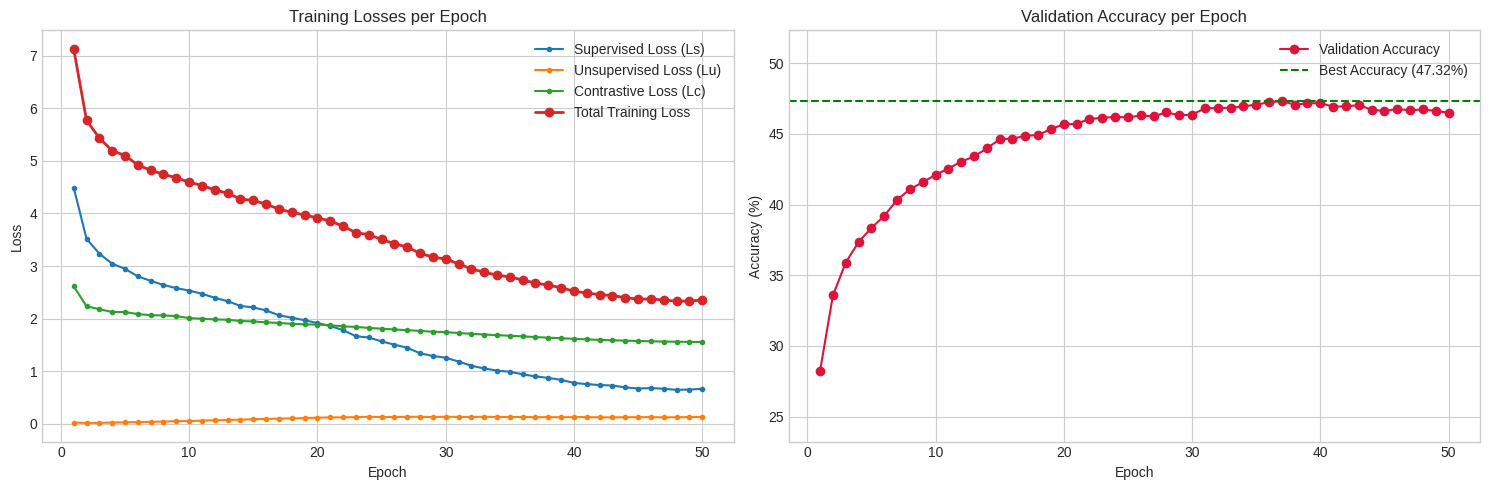


--- Overfitting/Underfitting Analysis ---
Observe the plots:
- Underfitting might be indicated if both Training Loss remains high and Validation Accuracy remains low and plateaus early.
- Good Fit is typically when Training Loss decreases steadily and Validation Accuracy increases steadily and plateaus at a high level.
- Overfitting might be indicated if Training Loss continues to decrease significantly while Validation Accuracy plateaus or starts to decrease.
-----------------------------------------


In [7]:
def plot_metrics(epochs_range, train_losses_s, train_losses_u, train_losses_c, train_losses_total, val_accuracies, best_acc):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Losses
    axes[0].plot(epochs_range, train_losses_s, label='Supervised Loss (Ls)', marker='.')
    axes[0].plot(epochs_range, train_losses_u, label='Unsupervised Loss (Lu)', marker='.')
    axes[0].plot(epochs_range, train_losses_c, label='Contrastive Loss (Lc)', marker='.')
    axes[0].plot(epochs_range, train_losses_total, label='Total Training Loss', marker='o', linewidth=2)
    axes[0].set_title('Training Losses per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Accuracy
    axes[1].plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o', color='crimson')
    axes[1].axhline(y=best_acc, color='green', linestyle='--', label=f'Best Accuracy ({best_acc:.2f}%)')
    axes[1].set_title('Validation Accuracy per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)
    # Dynamically set y-axis limits for better visibility if accuracy starts very low
    if len(val_accuracies) > 0:
      min_acc_display = max(0, min(val_accuracies)-5) # Start slightly below min accuracy but not below 0
      max_acc_display = min(100, max(val_accuracies)+5) # End slightly above max accuracy but not above 100
      if max_acc_display > min_acc_display: # Ensure valid range
            axes[1].set_ylim([min_acc_display, max_acc_display])


    plt.tight_layout()
    plt.show()

    # Interpretation for Overfitting/Underfitting:
    print("\n--- Overfitting/Underfitting Analysis ---")
    print("Observe the plots:")
    print("- Underfitting might be indicated if both Training Loss remains high and Validation Accuracy remains low and plateaus early.")
    print("- Good Fit is typically when Training Loss decreases steadily and Validation Accuracy increases steadily and plateaus at a high level.")
    print("- Overfitting might be indicated if Training Loss continues to decrease significantly while Validation Accuracy plateaus or starts to decrease.")
    print("-----------------------------------------")

# --- Plot the results ---
if EPOCHS > 0:
    epochs_plot = range(1, EPOCHS + 1)
    plot_metrics(epochs_plot, train_losses_s, train_losses_u, train_losses_c, train_losses_total, val_accuracies, best_val_acc)
else:
    print("No epochs were run, cannot plot metrics.")